In [1]:
import os
import librosa
import numpy as np
import scipy
import scipy.signal as scisignal
import matplotlib.pyplot as plt
import pickle
import json

def save_obj(obj, directory, name ):
    with open(directory + name +  '.pkl', 'wb') as f:
        pickle.dump(obj, f, 4)

# Calculate Metric

In [ ]:
DIR = "./data"
os.listdir 

In [161]:
joints = np.load("../../keypoints3d/gBR_sFM_cAll_d05_mBR5_ch12.pkl", allow_pickle=True)['keypoints3d_optim']
audio = np.load("../data/audio_features/gBR_sFM_cAll_d05_mBR5_ch12.pkl", allow_pickle=True)

print(joints.shape)

(1771, 17, 3)


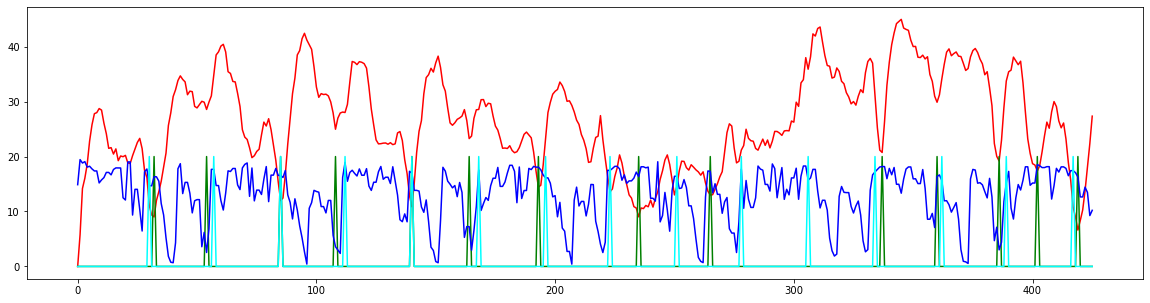

In [166]:
# Calculate velocity.
velocity = np.zeros_like(joints, dtype=np.float32)
velocity[1:] = joints[1:] - joints[:-1]
velocity_norms = np.linalg.norm(velocity, axis=2)
envelope = np.sum(velocity_norms, axis=1)  # (seq_len,)

# Find local minima in velocity -- beats
peak_idxs = scisignal.argrelextrema(envelope, np.less, axis=0, order=10) # 10 for 60FPS
peak_onehot = np.zeros_like(envelope, dtype=bool)
peak_onehot[peak_idxs] = 1



start = 0
end = 426

x = np.arange(0, peak_onehot[:-1].shape[0], 1)[start:end]



plt.figure(figsize=(20, 5))
plt.plot(x, envelope[:-1][start:end], 'red')          # motion-env
plt.plot(x, peak_onehot[:-1][start:end]*20, 'green')  # motion-peak
plt.plot(x, audio[:, 0][:-1][start:end]*20, "blue")        # music-env
plt.plot(x, audio[:, -1][:-1][start:end]*20, "cyan")       # beat



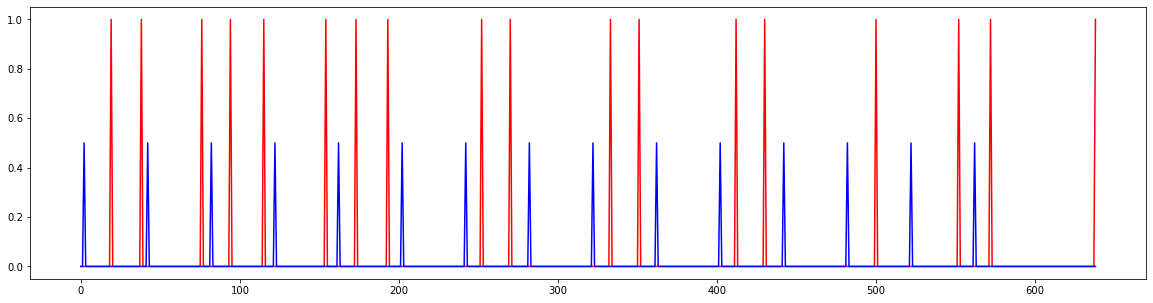

In [151]:

x = np.arange(0, peak_onehot[:-1].shape[0], 1)


plt.figure(figsize=(20, 5))
plt.plot(x, peak_onehot[:-1], 'red')
plt.plot(x, audio[:, -1]/2, "blue")

# Compare motions




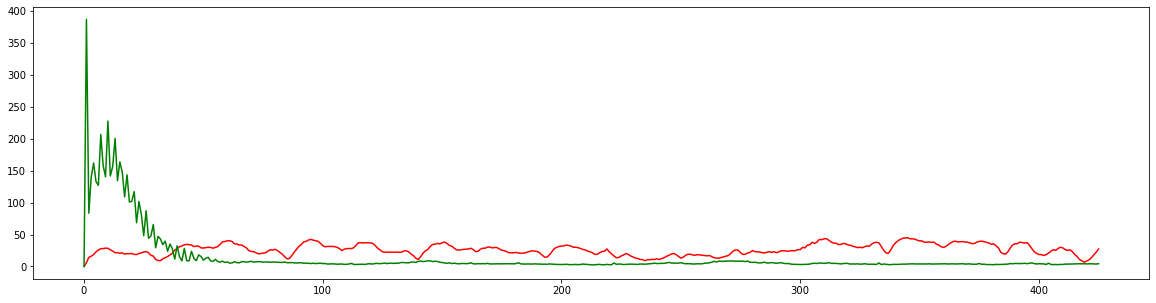

In [176]:
original = np.load("../../keypoints3d/gBR_sFM_cAll_d05_mBR5_ch12.pkl", allow_pickle=True)['keypoints3d_optim']
predicted = np.load("../prova.pkl", allow_pickle=True)

# Calculate velocity.
velocity = np.zeros_like(original, dtype=np.float32)
velocity[1:] = original[1:] - original[:-1]
velocity_norms = np.linalg.norm(velocity, axis=2)
envelope_original = np.sum(velocity_norms, axis=1)  # (seq_len,)

# Calculate velocity.
velocity = np.zeros_like(predicted, dtype=np.float32)
velocity[1:] = predicted[1:] - predicted[:-1]
velocity_norms = np.linalg.norm(velocity, axis=2)
envelope_predicted = np.sum(velocity_norms, axis=1)  # (seq_len,)


start = 0
end = 426

x = np.arange(0, peak_onehot[:-1].shape[0], 1)[start:end]



plt.figure(figsize=(20, 5))
plt.plot(x, envelope_original[start:end], 'red')        
plt.plot(x, envelope_predicted[start:end], 'green')  


# From keypoints3d to Blender

In [135]:


this_seq = joints

[n_frames, n_joints, n_dim] = this_seq.shape

normalised_seq = np.zeros((n_frames, n_joints+1, n_dim))

# For all the frames of the video
for i in range(this_seq.shape[0]):
    this_frame = this_seq[i]

    # Take left and right hip
    left_hip = this_frame[11]
    right_hip = this_frame[12]

    # and calculate the mean
    pelvis = (left_hip +  right_hip)/2

    # Normalise all the other joint with pelvis at the 0 center
    normalised_frame = this_frame - pelvis

    normalised_seq[i, :-1] = normalised_frame
    normalised_seq[i, n_joints] = pelvis

path_to = "comeStai"

# Save to .pkl file
save_obj(normalised_seq, "./", path_to)


# From json to Blender

In [181]:
path =  "../data/dataset/test/gBR_sFM_cAll_d05_mBR5_ch12_0.json"
    
with open(path) as f:
    sample = json.loads(f.read())
    dance = np.array(sample['motion'])
    
    dance = dance.reshape(dance.shape[0], 18, 3)

    path_to = "jsonToBlender"

    save_obj(dance, "./", path_to)

# BOP to Blender

In [19]:
BOP = np.array([-3.03933038,197.40993013, -4.02938249, -0.20411807,200.40658281
, -5.71477181, -5.875523, 200.34909549, -5.77308014, 3.37541695
,199.4787599, -12.3712766, -9.70917155,199.43009712,-12.22367906
, 9.0159848, 184.74933248,-17.24266724,-15.03735,  184.82223941
,-18.24799486, 18.45500438,170.64403929,-16.85775607,-23.73141296
,170.69377837,-18.6949286, 19.15359428,164.08866607, -9.77266799
,-24.92104784,164.24934035,-11.25820301, 5.22367735,139.70045774
,-21.42948912,-11.29685052,139.79198469,-22.19452003, 7.53424958
,108.51632543,-14.17712235,-14.2443059, 108.70790672,-15.0563787
, 7.12587562, 77.89924631,-22.50744766,-13.37533681, 78.14787432
,-23.43227194])

#BOP = BOP.reshape(1, 17, 3)

path_to = "BOP"

BOP = np.tile(BOP, (1, 1))
root = BOP[:, 3*11:3*12]
bos = BOP - np.tile(root, (1, 17))
bos[:,  3*11:3*12] = root
bos = bos.reshape(17, 3)

bos = bos.reshape(1, 51)
root = bos[:,3*11:3*12]
bos = bos + np.tile(root,(1,17))
bos[:,3*11:3*12] = root
bos = bos.reshape(bos.shape[0], 17, 3)

save_obj(bos, "./", path_to)

In [17]:
print(bos.shape)

(1, 17, 3)


In [14]:
bos

array([[-8.26300773e+00,  5.77094724e+01,  1.74001066e+01],
       [-5.42779542e+00,  6.07061251e+01,  1.57147173e+01],
       [-1.10992004e+01,  6.06486378e+01,  1.56564090e+01],
       [-1.84826040e+00,  5.97783022e+01,  9.05821252e+00],
       [-1.49328489e+01,  5.97296394e+01,  9.20581006e+00],
       [ 3.79230745e+00,  4.50488747e+01,  4.18682188e+00],
       [-2.02610273e+01,  4.51217817e+01,  3.18149426e+00],
       [ 1.32313270e+01,  3.09435816e+01,  4.57173305e+00],
       [-2.89550903e+01,  3.09933206e+01,  2.73456052e+00],
       [ 1.39299169e+01,  2.43882083e+01,  1.16568211e+01],
       [-3.01447252e+01,  2.45488826e+01,  1.01712861e+01],
       [ 5.22367735e+00,  1.39700458e+02, -2.14294891e+01],
       [-1.65205279e+01,  9.15269500e-02, -7.65030910e-01],
       [ 2.31057223e+00, -3.11841323e+01,  7.25236677e+00],
       [-1.94679832e+01, -3.09925510e+01,  6.37311042e+00],
       [ 1.90219827e+00, -6.18012114e+01, -1.07795854e+00],
       [-1.85990142e+01, -6.15525834e+01